In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Confirm GPU
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Global config
IMG_SIZE = 28
BATCH_SIZE = 128
EPOCHS = 40
LEARNING_RATE = 0.05
tf.keras.backend.clear_session()

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [57]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load images from folders
train_gen = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Compute class weights for balanced training
y_train_classes = train_gen.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weights_dict = dict(enumerate(class_weights_array))

Found 6895 images belonging to 10 classes.
Found 1969 images belonging to 10 classes.


In [58]:
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Dense layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


model.summary()

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/home/skipper/tf-venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,890 (1.67 MB)

 Trainable params: 437,738 (1.67 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [59]:
# Callbacks to prevent overfitting and save best model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

/home/skipper/tf-venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 453ms/step - accuracy: 0.5182 - loss: 1.7156 - val_accuracy: 0.1016 - val_loss: 531.0215
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.8517 - loss: 0.4112 - val_accuracy: 0.1021 - val_loss: 92.9282
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.9031 - loss: 0.2852 - val_accuracy: 0.1965 - val_loss: 19.2687
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.9221 - loss: 0.2452 - val_accuracy: 0.1935 - val_loss: 39.8935
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.7864 - loss: 0.7089 - val_accuracy: 0.1041 - val_loss: 61.6990
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 339ms/step - accuracy: 0.9002 - loss: 0.2999 - val_accuracy: 0.5251 - val_loss: 2.8101
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.9340 - loss: 0.2086 - val_accuracy: 0.8730 - val_loss: 0.4533
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.9467 - loss: 0.1627 - va

In [63]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc * 100:.2f}%")

Found 985 images belonging to 10 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.9936 - loss: 0.0190
Test Accuracy: 99.19%


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step


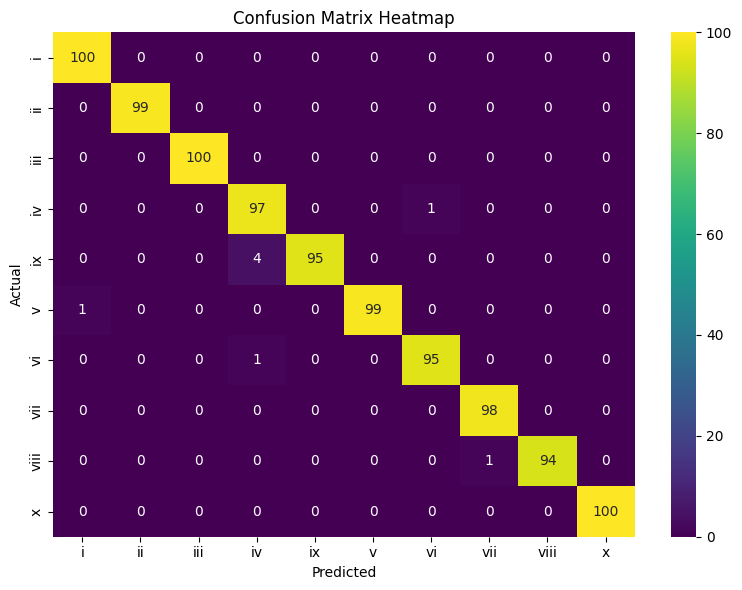

In [61]:
# Predict labels
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_gen.class_indices.keys())

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


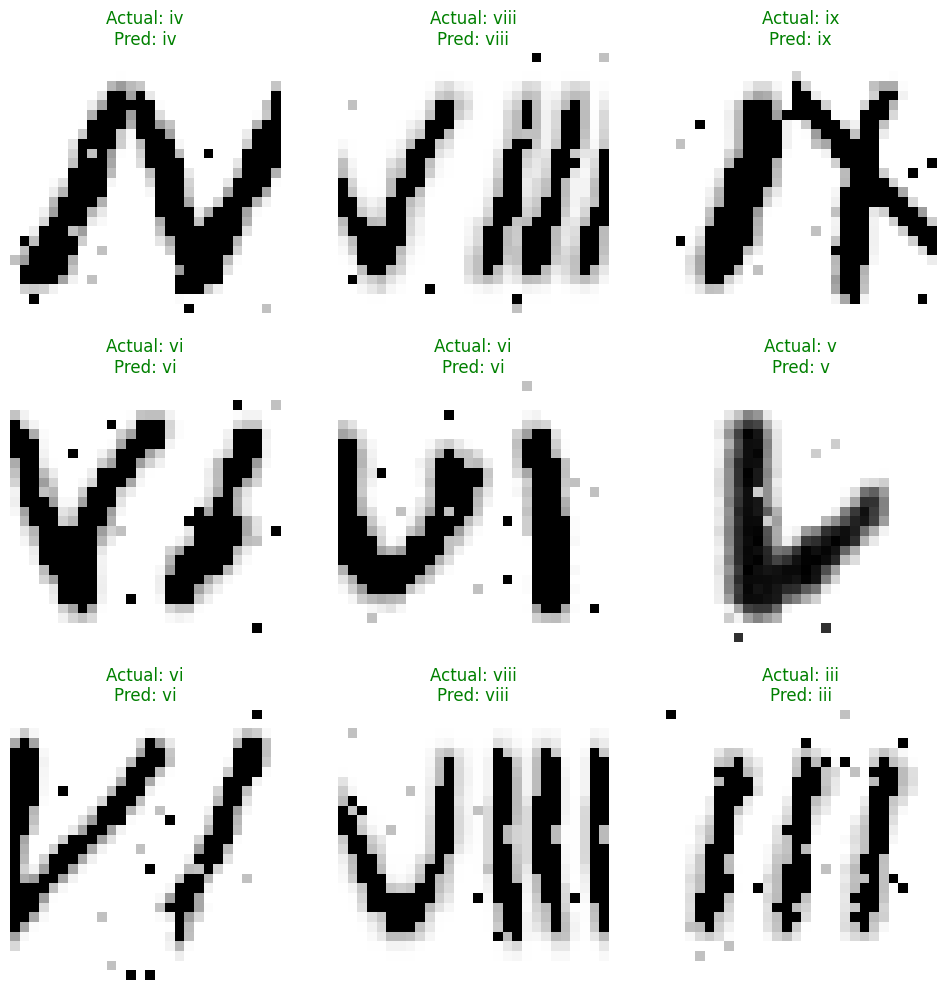

In [65]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Load all test images and labels
x_test, y_test = next(test_gen)
for _ in range((test_gen.samples // test_gen.batch_size) - 1):
    x_batch, y_batch = next(test_gen)
    x_test = np.concatenate((x_test, x_batch))
    y_test = np.concatenate((y_test, y_batch))

# Predict on all test images
preds = model.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(preds, axis=1)

# Map class indices to label names
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

# Pick 9 random indices
random_indices = random.sample(range(len(x_test)), 9)

# Plot
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    actual = idx_to_class[y_true[idx]]
    predicted = idx_to_class[y_pred[idx]]
    color = 'green' if actual == predicted else 'red'
    plt.title(f"Actual: {actual}\nPred: {predicted}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()
